In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#!pip install tensorflow-addons==0.8.3
#!pip install -U tensorflow-addons
!pip install vit-keras

Looking in indexes: http://pypi.douban.com/simple
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19567 sha256=2b304897d59612184e73759eb6178193fb7a1077f508283ce93caf9fc0eda6a2
  Stored in directory: /home/song/.cache/pip/wheels/63/ed/7a/3a7e78941f4491f5976742090eb5d68e67941500c811c66f86
Successfully built validators


In [8]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
# from vit_keras import vit, utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
# import tensorflow_addons as tfa
#import gdown
import zipfile
from io import BytesIO
# import tensorflow_hub as hub
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Data Loading
# set root as images folder path of dataset
root ="/home/song/Downloads/Bhai_data_analysis/Chest_Xray/ChestXRay2017/data/train"


# read dataset
base_dir = os.path.join(root)
PNEUMONIA_dir = os.path.join(base_dir,'PNEUMONIA')
NORMAL_dir = os.path.join(base_dir,'NORMAL')


PNEUMONIA_files = glob.glob(PNEUMONIA_dir+'/*.jpeg')
NORMAL_files = glob.glob(NORMAL_dir+'/*.jpeg')


len(PNEUMONIA_files), len(NORMAL_files)

(3883, 1349)

In [3]:
#Check top 5 rows of data
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': PNEUMONIA_files + NORMAL_files,
    'label': ['Pneumonia'] * len(PNEUMONIA_files) + ['Normal'] * len(NORMAL_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia
1,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia
2,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia
3,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia
4,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia


Data Preprocessing

In [9]:
# Data Splitting
# Partition dataset into training(60),testing(30),validation(10) 
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)

print(train_files.shape,  test_files.shape)
print('Train:', Counter(train_labels),  '\nTest:', Counter(test_labels))

(3662,) (1570,)
Train: Counter({'Pneumonia': 2720, 'Normal': 942}) 
Test: Counter({'Pneumonia': 1163, 'Normal': 407})


In [10]:
#Watershed segmentation
def segmentation(image):
  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #Performing Otsu's Binarization : This means that if the value of the pixel exceeds the threshold, it would be considered as 1. Else, 0
  ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  #print("Threshold limit: " + str(ret))

  #Specifying the Background and Foreground after Noise Removal
  # noise removal
  kernel = np.ones((3, 3), np.uint8)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

  # sure background area
  sure_bg = cv2.dilate(opening, kernel, iterations = 3)

  #Performing Distance Transfrom : In distance transfrom, the gray level intensities of the points inside the foreground
  # are changed to distance their respective distances from the closest 0 value
  
  # sure foreground area
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)

  # Connected Components
  ret, markers = cv2.connectedComponents(sure_fg)
  markers = markers + 1
  markers[unknown==255] = 0

  #Applying Watershed Segmentation
  markers = cv2.watershed(image, markers)
  image[markers == -1] = [0, 255,0]
  return image

In [11]:
# Image Resizing and Watershed Segmentation
IMG_DIMS = (64,64)
INPUT_SHAPE = (64,64, 3)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = segmentation(img)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape,  test_data.shape

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_0: working on img num: 3661

Loading Test Images:
ThreadPoolExecutor-0_7: working on img num: 0
ThreadPoolExecutor-0_9: working on img num: 1569


((3662, 64, 64, 3), (1570, 64, 64, 3))

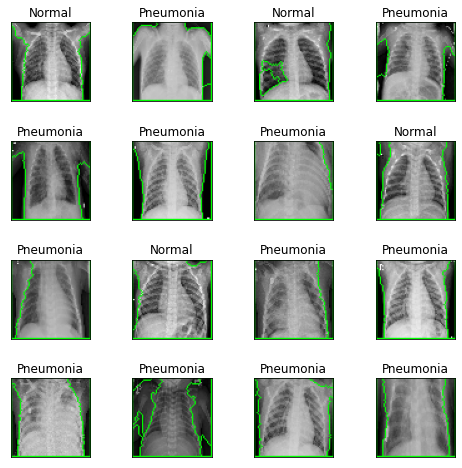

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [13]:
import tensorflow as tf
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

'2.4.1'

In [14]:
# Normalization of data 
x_train = train_data / 255.
x_test = test_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
test_labels_enc = le.transform(test_labels)

y_train = keras.utils.to_categorical(train_labels_enc, 4)
y_test = keras.utils.to_categorical(test_labels_enc, 4)

print(train_labels_enc[:6], y_train[:6])

[1 1 1 1 1 1] [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [17]:
# data_augmentation = keras.Sequential(
#     [
#         layers.Normalization(),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.1),
#         layers.RandomContrast(factor=0.1),
#         layers.RandomZoom(height_factor=0.2, width_factor=0.2),
#     ],
#     name="data_augmentation",
# )
# data_augmentation(x_train)

# # Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)


import tensorflow as tf
from tensorflow.keras import layers

# ... Rest of the code ...

# Define the normalization layer separately
normalization_layer = layers.experimental.preprocessing.Normalization()
normalization_layer.adapt(x_train)

# Define the RandomRotation and RandomZoom layers separately
rotation_layer = layers.experimental.preprocessing.RandomRotation(factor=0.1)
zoom_layer = layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2)

# Apply normalization, rotation, and zoom to the input data before data augmentation
x_train_normalized = normalization_layer(x_train)
x_test_normalized = normalization_layer(x_test)

x_train_augmented = rotation_layer(x_train_normalized)
x_train_augmented = zoom_layer(x_train_augmented)

x_test_augmented = rotation_layer(x_test_normalized)
x_test_augmented = zoom_layer(x_test_augmented)

# Define the data_augmentation pipeline for the remaining augmentations
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomContrast(factor=0.1),
], name="data_augmentation")


# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


# EANet Model

In [22]:
# !pip install --upgrade tensorflow
!pip install --upgrade tensorflow-addons

Looking in indexes: http://pypi.douban.com/simple
     |████████████████████████████████| 524.1 MB 19 kB/s  eta 0:00:015     |████████▌                       | 139.9 MB 1.3 MB/s eta 0:04:52     |█████████                       | 146.0 MB 3.6 MB/s eta 0:01:46     |████████████████████████████▍   | 465.1 MB 3.9 MB/s eta 0:00:16
     |████████████████████████████████| 585.9 MB 18 kB/s  eta 0:00:013    |████████████                    | 220.7 MB 1.9 MB/s eta 0:03:08     |█████████████▊                  | 251.9 MB 7.2 MB/s eta 0:00:47     |███████████████▍                | 280.8 MB 507 kB/s eta 0:10:01     |██████████████████▏             | 333.0 MB 1.6 MB/s eta 0:02:40     |██████████████████████          | 402.1 MB 1.0 MB/s eta 0:03:00     |████████████████████████        | 440.0 MB 921 kB/s eta 0:02:39
     |████████████████████████████████| 440 kB 2.7 kB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 72 kB/s  eta 0:00:01
     |████████████████████████████████| 304 kB 1.4 M

     |████████████████████████████████| 182 kB 1.6 MB/s eta 0:00:01
  Created wheel for jax: filename=jax-0.4.12-py3-none-any.whl size=1498447 sha256=fd23b0c13f47df84e76c3882bf0499b5b3968b548e936f2b052ab0ed4ebf1e9e
  Stored in directory: /home/song/.cache/pip/wheels/33/7d/1b/7888c75e317518e8527261376e6a907b7b2108d59ff2e4e01a
Successfully built jax
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.6.0
    Uninstalling google-auth-2.6.0:
      Successfully uninstalled google-auth-2.6.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1
  Attempting uni

In [23]:
from vit_keras import vit, utils

image_size = 64
model = vit.vit_l32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=2
)

# Hyper-parameters

weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1

model.compile(
    loss=keras.losses.BinaryCrossentropyCrossentropy(label_smoothing=label_smoothing),
    optimizer= tf.optimizers.Adam(
         learning_rate=learning_rate#, weight_decay=weight_decay
    ),
    #optimizer=tfa.optimizers.AdamW( learning_rate=learning_rate, weight_decay=weight_decay),
    metrics=[
        keras.metrics.BinaryCrossentropyAccuracy(name="accuracy"),
    ],
)
model.summary()

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'dispatch'

In [ ]:
history = model.fit(x_train,y_train,batch_size=64,epochs=10,validation_split=0.2)

Epoch 1/10
110/110 [==============================] - 33s 300ms/step - loss: 0.3593 - accuracy: 0.9968 - val_loss: 0.3521 - val_accuracy: 0.9983
Epoch 2/10
110/110 [==============================] - 33s 300ms/step - loss: 0.3502 - accuracy: 0.9999 - val_loss: 0.3498 - val_accuracy: 1.0000
Epoch 3/10
110/110 [==============================] - 33s 304ms/step - loss: 0.3502 - accuracy: 0.9999 - val_loss: 0.3497 - val_accuracy: 0.9994
Epoch 4/10
110/110 [==============================] - 33s 299ms/step - loss: 0.3500 - accuracy: 0.9999 - val_loss: 0.3501 - val_accuracy: 0.9994
Epoch 5/10
110/110 [==============================] - 33s 300ms/step - loss: 0.3500 - accuracy: 0.9999 - val_loss: 0.3500 - val_accuracy: 0.9994
Epoch 6/10
110/110 [==============================] - 33s 303ms/step - loss: 0.3499 - accuracy: 0.9999 - val_loss: 0.3501 - val_accuracy: 0.9994
Epoch 7/10
110/110 [==============================] - 33s 301ms/step - loss: 0.3500 - accuracy: 0.9999 - val_loss: 0.3500 - val_ac

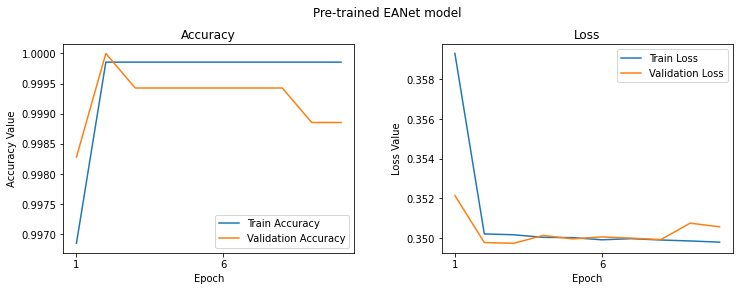

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained EANet model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('KidneyStoneDetector_pretrainedEANetv3.h5')

In [ ]:
# Model evaluated on training data
score = model.evaluate(x_train, y_train, verbose=0)
print('Training score:', score[0])
print('Training accuracy:', score[1] * 100)


Training score: 0.34966734051704407
Training accuracy: 99.96561408042908


In [ ]:
# Model evaluated on testing data
score= model.evaluate(x_test, y_test, verbose=0)
print('Testing score:', score[0])
print('Testing accuracy:', score[1] * 100)

Training score: 0.35084694623947144
Training accuracy: 99.91978406906128


In [ ]:
y_pre_test=model.predict(x_test)
y_pre_test=np.argmax(y_pre_test,axis=1)
categories = ['Cyst','Normal', 'Stone','Tumor']
test_labels_enc[:6], y_pre_test[:6]

(array([1, 2, 2, 1, 0, 1]), array([1, 2, 2, 1, 0, 1]))

In [ ]:
clf_report = pd.DataFrame(classification_report(test_labels_enc, y_pre_test,target_names=categories, output_dict=True))
cm = confusion_matrix(test_labels_enc, y_pre_test)
print("Test Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(test_labels_enc, y_pre_test) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")

Test Result:
Accuracy Score: 99.92%
_______________________________________________
CLASSIFICATION REPORT:
             Cyst       Normal       Stone  Tumor  accuracy    macro avg  \
precision     1.0     0.997992    1.000000    1.0  0.999198     0.999498   
recall        1.0     1.000000    0.992611    1.0  0.999198     0.998153   
f1-score      1.0     0.998995    0.996292    1.0  0.999198     0.998822   
support    1158.0  1491.000000  406.000000  685.0  0.999198  3740.000000   

           weighted avg  
precision      0.999199  
recall         0.999198  
f1-score       0.999197  
support     3740.000000  


In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import seaborn as sn
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    #y_score = clf.decision_function(X_test)
    y_score=model.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sn.despine()
    plt.show()

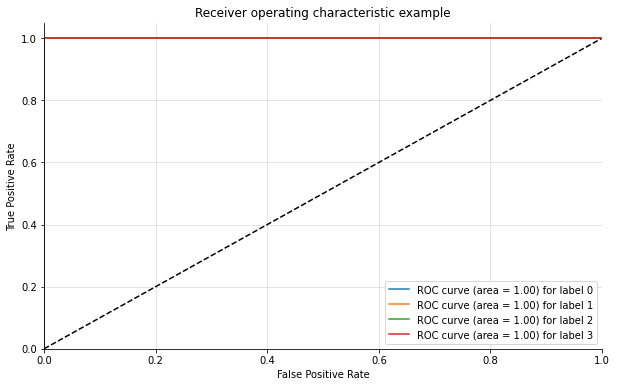

In [ ]:
plot_multiclass_roc(model, x_test, test_labels_enc, n_classes=4, figsize=(10, 6))

In [ ]:
# ROC AUC scores
y_pred=model.predict(x_test)
macro_roc_auc_ovo = roc_auc_score(test_labels_enc, y_pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(test_labels_enc, y_pred, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(test_labels_enc,y_pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(test_labels_enc, y_pred, multi_class="ovr", average="weighted")
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.999999 (macro),
1.000000 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999999 (macro),
1.000000 (weighted by prevalence)


In [ ]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

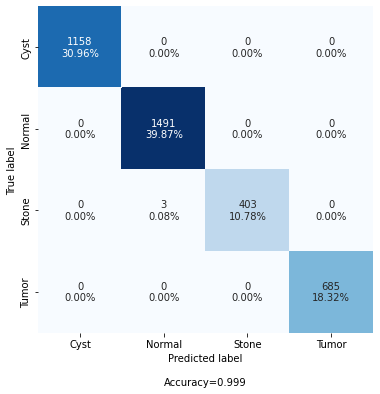

In [ ]:
# Cyst = 0 ,  Normal =1  , Stone =2 , Tumor = 3
categories = ['Cyst','Normal', 'Stone','Tumor']
make_confusion_matrix(cm, categories=categories,figsize=(6,6), cbar=False)
plt.savefig("ConfusionMatrix.png")